# Data Augmentation
This notebook performs data augmentation on the dataset by creating an augmented copy of each image in the original dataset. Original dataset images are taken from the ```dataset``` folder, while original and augmented images are saved to the ```dataset-augmented``` folder.

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Folders for input (original images) and output (original + augmented images)
in_folder = r"dataset/"
out_folder = r"dataset-augmented/"

In [3]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [4]:
# Convert PIL Image to tensor
to_tensor = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

translation_matrix = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])

# Transformations to apply to inputs, where one is randomly chosen and applied per image
augmentations = transforms.RandomChoice([
    # Rotate by a random amount within -3 to -1 degrees
    transforms.RandomRotation(degrees=(-3, -1), fill=255), 
    
    # Rotate by a random amount within 1 to 3 degrees
    transforms.RandomRotation(degrees=(1, 3), fill=255), 
    
    # Translate horizontally by a random percentage between -15% and 15% and
    # vertically by a random percentage between -15% and 15%
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), fill=255), 
    
    # Horizontally flips the image
    transforms.RandomHorizontalFlip(p=1)
])

In [5]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Augment Data

In [6]:
# Image dataset
class AugmentedDataset(Dataset):
    def __init__(self, img_dir, to_tensor, augment):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",")
        self.to_tensor = to_tensor
        self.augment = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Augment image
        image = Image.open(img_path).convert("RGB")
        image = self.to_tensor(image)
        image = self.augment(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label, filename

In [7]:
# Dataset and dataloader for images
data = AugmentedDataset(img_dir=in_folder, to_tensor=to_tensor, augment=augmentations)
loader = DataLoader(data, batch_size=10, shuffle=True)

### Show Sample of Augmented Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes: 0 0 0 1 0 0 0 0 0 1
Original files:
0729-0-P.tif
0220-0-A.tif
0814-0-A.tif
0191-1-P.tif
0085-0-P.tif
1151-0-P.tif
0371-0-P.tif
0678-0-A.tif
0752-0-A.tif
0760-1-A.tif


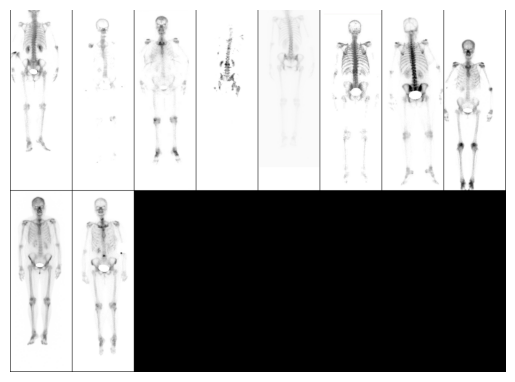

In [8]:
# Show random augmented images and their ground truth classes
dataiter = iter(loader)
images, labels, filenames = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))
print("Original files:\n" + '\n'.join(f'{filenames[j]}' for j in range(len(filenames))))

### Save Augmented Images to Output Folder

In [9]:
# Copy original images to output folder
for filename in os.listdir(in_folder):
    in_file = os.path.join(in_folder, filename)
    shutil.copy(in_file, out_folder)

In [10]:
# Get index of last original image
last_filename = os.listdir(in_folder)[-1]
img_index = int(last_filename[0:4])

In [11]:
# Delete all previous copies of augmented images in folder (if any)
for filename in os.listdir(out_folder):
    if (int(filename[0:4]) > img_index):
        os.remove(os.path.join(out_folder, filename))

In [12]:
for batch_index, batch_data in enumerate(loader):
    # Get the images, labels, and filenames in the current batch
    images, labels, orig_filenames = batch_data
    
    for i in range(len(images)):
        # Create filename for augmented image
        img_index += 1
        new_filename = str(img_index) + orig_filenames[i][4:]
        img_path = out_folder + "/" + new_filename
        
        # Save augmented image
        save_image(images[i], img_path)
        print(f"Saved augmented copy of {orig_filenames[i]} as {new_filename} in {out_folder}")

Saved augmented copy of 0641-0-P.tif as 1226-0-P.tif in dataset-augmented/
Saved augmented copy of 0953-0-A.tif as 1227-0-A.tif in dataset-augmented/
Saved augmented copy of 1221-1-P.tif as 1228-1-P.tif in dataset-augmented/
Saved augmented copy of 0077-0-P.tif as 1229-0-P.tif in dataset-augmented/
Saved augmented copy of 0139-0-P.tif as 1230-0-P.tif in dataset-augmented/
Saved augmented copy of 1174-0-P.tif as 1231-0-P.tif in dataset-augmented/
Saved augmented copy of 0843-0-A.tif as 1232-0-A.tif in dataset-augmented/
Saved augmented copy of 0339-0-P.tif as 1233-0-P.tif in dataset-augmented/
Saved augmented copy of 0825-0-A.tif as 1234-0-A.tif in dataset-augmented/
Saved augmented copy of 0020-0-A.tif as 1235-0-A.tif in dataset-augmented/
Saved augmented copy of 0296-0-P.tif as 1236-0-P.tif in dataset-augmented/
Saved augmented copy of 1202-1-P.tif as 1237-1-P.tif in dataset-augmented/
Saved augmented copy of 0950-0-A.tif as 1238-0-A.tif in dataset-augmented/
Saved augmented copy of 1

Saved augmented copy of 0749-1-P.tif as 1336-1-P.tif in dataset-augmented/
Saved augmented copy of 1201-1-P.tif as 1337-1-P.tif in dataset-augmented/
Saved augmented copy of 0037-0-P.tif as 1338-0-P.tif in dataset-augmented/
Saved augmented copy of 0282-0-P.tif as 1339-0-P.tif in dataset-augmented/
Saved augmented copy of 0074-0-A.tif as 1340-0-A.tif in dataset-augmented/
Saved augmented copy of 1130-0-P.tif as 1341-0-P.tif in dataset-augmented/
Saved augmented copy of 1061-0-P.tif as 1342-0-P.tif in dataset-augmented/
Saved augmented copy of 0211-1-P.tif as 1343-1-P.tif in dataset-augmented/
Saved augmented copy of 0066-0-A.tif as 1344-0-A.tif in dataset-augmented/
Saved augmented copy of 1180-1-P.tif as 1345-1-P.tif in dataset-augmented/
Saved augmented copy of 0198-0-A.tif as 1346-0-A.tif in dataset-augmented/
Saved augmented copy of 0764-0-A.tif as 1347-0-A.tif in dataset-augmented/
Saved augmented copy of 0883-0-A.tif as 1348-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0583-0-P.tif as 1446-0-P.tif in dataset-augmented/
Saved augmented copy of 0847-0-A.tif as 1447-0-A.tif in dataset-augmented/
Saved augmented copy of 0540-1-A.tif as 1448-1-A.tif in dataset-augmented/
Saved augmented copy of 0119-1-P.tif as 1449-1-P.tif in dataset-augmented/
Saved augmented copy of 0157-1-P.tif as 1450-1-P.tif in dataset-augmented/
Saved augmented copy of 1030-0-P.tif as 1451-0-P.tif in dataset-augmented/
Saved augmented copy of 0319-1-P.tif as 1452-1-P.tif in dataset-augmented/
Saved augmented copy of 0085-0-P.tif as 1453-0-P.tif in dataset-augmented/
Saved augmented copy of 1173-0-P.tif as 1454-0-P.tif in dataset-augmented/
Saved augmented copy of 1190-1-P.tif as 1455-1-P.tif in dataset-augmented/
Saved augmented copy of 1028-0-P.tif as 1456-0-P.tif in dataset-augmented/
Saved augmented copy of 0911-0-A.tif as 1457-0-A.tif in dataset-augmented/
Saved augmented copy of 0366-0-A.tif as 1458-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0654-0-A.tif as 1556-0-A.tif in dataset-augmented/
Saved augmented copy of 0543-0-P.tif as 1557-0-P.tif in dataset-augmented/
Saved augmented copy of 0849-0-A.tif as 1558-0-A.tif in dataset-augmented/
Saved augmented copy of 0482-0-A.tif as 1559-0-A.tif in dataset-augmented/
Saved augmented copy of 0136-0-A.tif as 1560-0-A.tif in dataset-augmented/
Saved augmented copy of 1212-1-P.tif as 1561-1-P.tif in dataset-augmented/
Saved augmented copy of 0599-1-P.tif as 1562-1-P.tif in dataset-augmented/
Saved augmented copy of 0160-0-A.tif as 1563-0-A.tif in dataset-augmented/
Saved augmented copy of 0248-1-A.tif as 1564-1-A.tif in dataset-augmented/
Saved augmented copy of 0501-1-P.tif as 1565-1-P.tif in dataset-augmented/
Saved augmented copy of 0182-0-A.tif as 1566-0-A.tif in dataset-augmented/
Saved augmented copy of 0151-1-P.tif as 1567-1-P.tif in dataset-augmented/
Saved augmented copy of 0840-0-A.tif as 1568-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0988-1-A.tif as 1666-1-A.tif in dataset-augmented/
Saved augmented copy of 0478-1-A.tif as 1667-1-A.tif in dataset-augmented/
Saved augmented copy of 0728-0-A.tif as 1668-0-A.tif in dataset-augmented/
Saved augmented copy of 1211-1-P.tif as 1669-1-P.tif in dataset-augmented/
Saved augmented copy of 1194-1-P.tif as 1670-1-P.tif in dataset-augmented/
Saved augmented copy of 0439-0-P.tif as 1671-0-P.tif in dataset-augmented/
Saved augmented copy of 0836-0-A.tif as 1672-0-A.tif in dataset-augmented/
Saved augmented copy of 0134-1-A.tif as 1673-1-A.tif in dataset-augmented/
Saved augmented copy of 0681-0-P.tif as 1674-0-P.tif in dataset-augmented/
Saved augmented copy of 0939-0-A.tif as 1675-0-A.tif in dataset-augmented/
Saved augmented copy of 0774-0-A.tif as 1676-0-A.tif in dataset-augmented/
Saved augmented copy of 0966-1-A.tif as 1677-1-A.tif in dataset-augmented/
Saved augmented copy of 0594-0-A.tif as 1678-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 1110-0-P.tif as 1776-0-P.tif in dataset-augmented/
Saved augmented copy of 0095-1-P.tif as 1777-1-P.tif in dataset-augmented/
Saved augmented copy of 0050-0-A.tif as 1778-0-A.tif in dataset-augmented/
Saved augmented copy of 0115-1-P.tif as 1779-1-P.tif in dataset-augmented/
Saved augmented copy of 0509-0-P.tif as 1780-0-P.tif in dataset-augmented/
Saved augmented copy of 1150-0-P.tif as 1781-0-P.tif in dataset-augmented/
Saved augmented copy of 1054-0-P.tif as 1782-0-P.tif in dataset-augmented/
Saved augmented copy of 1098-0-P.tif as 1783-0-P.tif in dataset-augmented/
Saved augmented copy of 0373-1-P.tif as 1784-1-P.tif in dataset-augmented/
Saved augmented copy of 0143-0-P.tif as 1785-0-P.tif in dataset-augmented/
Saved augmented copy of 0819-0-A.tif as 1786-0-A.tif in dataset-augmented/
Saved augmented copy of 0333-0-P.tif as 1787-0-P.tif in dataset-augmented/
Saved augmented copy of 0168-1-A.tif as 1788-1-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0675-1-P.tif as 1887-1-P.tif in dataset-augmented/
Saved augmented copy of 0522-0-A.tif as 1888-0-A.tif in dataset-augmented/
Saved augmented copy of 0421-1-P.tif as 1889-1-P.tif in dataset-augmented/
Saved augmented copy of 0949-0-A.tif as 1890-0-A.tif in dataset-augmented/
Saved augmented copy of 0881-0-A.tif as 1891-0-A.tif in dataset-augmented/
Saved augmented copy of 0621-0-P.tif as 1892-0-P.tif in dataset-augmented/
Saved augmented copy of 0321-1-P.tif as 1893-1-P.tif in dataset-augmented/
Saved augmented copy of 0893-0-A.tif as 1894-0-A.tif in dataset-augmented/
Saved augmented copy of 0219-1-A.tif as 1895-1-A.tif in dataset-augmented/
Saved augmented copy of 0790-0-A.tif as 1896-0-A.tif in dataset-augmented/
Saved augmented copy of 0672-1-A.tif as 1897-1-A.tif in dataset-augmented/
Saved augmented copy of 1093-0-P.tif as 1898-0-P.tif in dataset-augmented/
Saved augmented copy of 0564-0-A.tif as 1899-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0826-0-A.tif as 2006-0-A.tif in dataset-augmented/
Saved augmented copy of 0625-0-P.tif as 2007-0-P.tif in dataset-augmented/
Saved augmented copy of 0788-1-A.tif as 2008-1-A.tif in dataset-augmented/
Saved augmented copy of 0991-1-A.tif as 2009-1-A.tif in dataset-augmented/
Saved augmented copy of 0528-0-P.tif as 2010-0-P.tif in dataset-augmented/
Saved augmented copy of 0155-0-P.tif as 2011-0-P.tif in dataset-augmented/
Saved augmented copy of 0978-1-A.tif as 2012-1-A.tif in dataset-augmented/
Saved augmented copy of 0263-1-P.tif as 2013-1-P.tif in dataset-augmented/
Saved augmented copy of 1031-0-P.tif as 2014-0-P.tif in dataset-augmented/
Saved augmented copy of 0669-1-P.tif as 2015-1-P.tif in dataset-augmented/
Saved augmented copy of 1179-1-P.tif as 2016-1-P.tif in dataset-augmented/
Saved augmented copy of 0455-0-P.tif as 2017-0-P.tif in dataset-augmented/
Saved augmented copy of 1197-1-P.tif as 2018-1-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0685-0-P.tif as 2116-0-P.tif in dataset-augmented/
Saved augmented copy of 0035-0-P.tif as 2117-0-P.tif in dataset-augmented/
Saved augmented copy of 0676-0-P.tif as 2118-0-P.tif in dataset-augmented/
Saved augmented copy of 0038-0-A.tif as 2119-0-A.tif in dataset-augmented/
Saved augmented copy of 0184-0-A.tif as 2120-0-A.tif in dataset-augmented/
Saved augmented copy of 0334-0-A.tif as 2121-0-A.tif in dataset-augmented/
Saved augmented copy of 1178-1-P.tif as 2122-1-P.tif in dataset-augmented/
Saved augmented copy of 0130-0-A.tif as 2123-0-A.tif in dataset-augmented/
Saved augmented copy of 0512-0-A.tif as 2124-0-A.tif in dataset-augmented/
Saved augmented copy of 0270-1-A.tif as 2125-1-A.tif in dataset-augmented/
Saved augmented copy of 1034-0-P.tif as 2126-0-P.tif in dataset-augmented/
Saved augmented copy of 0018-0-P.tif as 2127-0-P.tif in dataset-augmented/
Saved augmented copy of 0447-0-P.tif as 2128-0-P.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0108-0-A.tif as 2226-0-A.tif in dataset-augmented/
Saved augmented copy of 0027-1-P.tif as 2227-1-P.tif in dataset-augmented/
Saved augmented copy of 0586-1-A.tif as 2228-1-A.tif in dataset-augmented/
Saved augmented copy of 1000-1-A.tif as 2229-1-A.tif in dataset-augmented/
Saved augmented copy of 0488-0-P.tif as 2230-0-P.tif in dataset-augmented/
Saved augmented copy of 0610-0-A.tif as 2231-0-A.tif in dataset-augmented/
Saved augmented copy of 0983-1-A.tif as 2232-1-A.tif in dataset-augmented/
Saved augmented copy of 0280-1-A.tif as 2233-1-A.tif in dataset-augmented/
Saved augmented copy of 0689-0-P.tif as 2234-0-P.tif in dataset-augmented/
Saved augmented copy of 1120-0-P.tif as 2235-0-P.tif in dataset-augmented/
Saved augmented copy of 0242-1-A.tif as 2236-1-A.tif in dataset-augmented/
Saved augmented copy of 0384-0-A.tif as 2237-0-A.tif in dataset-augmented/
Saved augmented copy of 0914-0-A.tif as 2238-0-A.tif in dataset-augmented/
Saved augmented copy of 0

Saved augmented copy of 0784-0-A.tif as 2336-0-A.tif in dataset-augmented/
Saved augmented copy of 0140-0-A.tif as 2337-0-A.tif in dataset-augmented/
Saved augmented copy of 0626-0-A.tif as 2338-0-A.tif in dataset-augmented/
Saved augmented copy of 0065-0-P.tif as 2339-0-P.tif in dataset-augmented/
Saved augmented copy of 0612-0-A.tif as 2340-0-A.tif in dataset-augmented/
Saved augmented copy of 0487-0-P.tif as 2341-0-P.tif in dataset-augmented/
Saved augmented copy of 0305-1-P.tif as 2342-1-P.tif in dataset-augmented/
Saved augmented copy of 0158-0-A.tif as 2343-0-A.tif in dataset-augmented/
Saved augmented copy of 0995-1-A.tif as 2344-1-A.tif in dataset-augmented/
Saved augmented copy of 1049-0-P.tif as 2345-0-P.tif in dataset-augmented/
Saved augmented copy of 0744-0-A.tif as 2346-0-A.tif in dataset-augmented/
Saved augmented copy of 0265-1-P.tif as 2347-1-P.tif in dataset-augmented/
Saved augmented copy of 0425-0-P.tif as 2348-0-P.tif in dataset-augmented/
Saved augmented copy of 0